# Corn Yield Prediction 

Below is is v0 of Kristin's corn yield prediction model (using 3 measurements of SIF and walk forward validation) and steps I followed:

1. Create a baseline linear model using the provided formula and treat it as benchmark. (only at national level)
2. Retrieve Data from Fused UDF-Cornucopia 
3. Implement a Random Forest model for yield prediction (at county level)
4. Perform a walk-forward validation (train/test splits by year).
5. Reserve a final holdout set to measure out-of-sample performance.


## 1. Baseline Model

Baseline model gathered data from this image (https://www.nass.usda.gov/Charts_and_Maps/Field_Crops/cornyld.php) using data previous to 2015 and removing outliers.

In [195]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
    
    
#Create baseline model based on USDA Screenshot data from 1995
# Data extracted from the chart
years = np.array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2013, 2014]).reshape(-1, 1)
yields = np.array([113.5, 127.1, 126.7, 134.4, 133.8, 136.9, 138.2, 129.3, 142.2, 160.3, 147.9, 150.7, 153.3, 152.6, 164.4, 146.8, 158.1, 158.1, 171.0])

# Remove outliers
q1, q3 = np.percentile(yields, [25, 75])
iqr = q3 - q1
mask = (yields >= q1 - 1.5 * iqr) & (yields <= q3 + 1.5 * iqr)
years, yields = years[mask], yields[mask]

# Fit and predict
model = LinearRegression().fit(years, yields)
yield_predictions = model.predict(years)

# Predict for 2015-2020
target_years = np.array(range(2015, 2021)).reshape(-1, 1)
predictions = model.predict(target_years)

# Calculate error for the baseline model
baseline_predictions = model.predict(years)
mse = mean_squared_error(yields, baseline_predictions)

# Create a table for predictions
data = {
    "year": range(2015, 2021),
    "Predicted Yield (baseline)": predictions.round(2),
    "Actual Yield (USDA)": [168.4, 174.6, 176.6, 176.4, 167.5, 172.0],  # Hard-coded actual yields
    "USDA June Actual": [166.8, 168.0, 170.7, 174.0, 176.0, 178.5]  # Hard-coded USDA predictions
}
prediction_table = pd.DataFrame(data)

# Output table
print("\nPredicted Yields (2015-2020):")
print(prediction_table)


# Output model and error
print(f"Linear Model: Yield = {model.coef_[0]:.2f} * Year + {model.intercept_:.2f}")
print(f"Mean Squared Error: {mean_squared_error(yields, yield_predictions):.2f}")






Predicted Yields (2015-2020):
   year  Predicted Yield (baseline)  Actual Yield (USDA)  USDA June Actual
0  2015                      169.84                168.4             166.8
1  2016                      172.16                174.6             168.0
2  2017                      174.49                176.6             170.7
3  2018                      176.82                176.4             174.0
4  2019                      179.14                167.5             176.0
5  2020                      181.47                172.0             178.5
Linear Model: Yield = 2.33 * Year + -4518.23
Mean Squared Error: 40.42


## 2. Retrieve Data from Fused

### Connect to Fuseda and Use Cornucopia UDF. 

We specify the area for the UDF to download data by passing a GeoDataFrame to the bbox parameter.

In [196]:
# pip install fused -q

In [197]:
# # Run this cell, visit the URL, paste the provided credentials snippet in a new cell
# from fused.api import NotebookCredentials
# credentials = NotebookCredentials()

In [198]:
# credentials.finalize(code="_eLzl1HR2p7rPZ3JsKtqkMcPScc6R--WRYpaJwFyOJbGY")

In [199]:
import fused
import geopandas as gpd
import shapely
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# bbox = gpd.GeoDataFrame(
#     geometry=[shapely.box(-73.9847, 40.7666, -73.9810, 40.7694)], 
#     crs=4326
# )
# bbox


### Run the Cornucopia UDF




In [188]:
df = fused.run('fsh_6zh59m43BXZwFulEbTBux4') 
df.head()


,GEOID,year,corn_sif_mean_05a,corn_sif_mean_05b,corn_sif_mean_06a,corn_sif_mean_06b,corn_sif_mean_07a,corn_sif_mean_07b,bushels_per_acre_actual,m_pct,bushels_sum_actual,geometry,area_county_acres,area_corn_acres
0,19001,2015,0.215304,0.236333,0.268287,0.406770,0.549103,0.680885,176.5,0.335000,2.163958e+07,"POLYGON ((-94.70063 41.50415, -94.69995 41.504...",3.659817e+13,122603.863902
1,19001,2016,0.208441,0.290762,0.290723,0.435775,0.644035,0.654245,190.3,0.355000,2.472444e+07,"POLYGON ((-94.70063 41.50415, -94.69995 41.504...",3.659817e+13,129923.497568
2,19001,2019,0.160860,0.216200,0.273115,0.373695,0.534655,0.602721,176.5,0.325000,2.099362e+07,"POLYGON ((-94.70063 41.50415, -94.69995 41.504...",3.659817e+13,118944.047069
3,19001,2020,0.155585,0.239596,0.317103,0.436632,0.598303,0.641528,168.7,0.315000,1.944845e+07,"POLYGON ((-94.70063 41.50415, -94.69995 41.504...",3.659817e+13,115284.230236
4,19003,2015,0.210918,0.221034,0.280065,0.367229,0.510651,0.623617,169.6,0.281667,1.304095e+07,"POLYGON ((-94.92759 41.15851, -94.91651 41.158...",2.729907e+13,76892.390977


In [189]:
df['year'].unique()

# Count the number of rows for each unique year
year_counts = df['year'].value_counts().sort_index()

# Display the result
print(year_counts)

year
2015    99
2016    99
2019    99
2020    99
Name: count, dtype: int64


In [190]:
# null_counts = df.isnull().sum()
# print(null_counts)


In [191]:
# print(df.describe())

### Year by Year Walk Forward


Simplified Method On Bushels per Acre 

     year  geoid  actual  predicted
0    2016  19001   190.3    190.697
1    2016  19003   187.4    161.798
2    2016  19005   205.1    169.925
3    2016  19007   186.3     83.009
4    2016  19009   206.1    193.689
..    ...    ...     ...        ...
292  2020  19189   207.1    183.783
293  2020  19191   178.2    205.286
294  2020  19193   191.0    167.774
295  2020  19195   205.7    196.751
296  2020  19197   186.0    202.252

[297 rows x 4 columns]
   year      actual  model1_pred
0  2016  200.142424   180.101010
1  2019  172.724242   194.559960
2  2020  167.949495   188.814222
Feature Importances:
                  Feature  Importance
6         area_corn_acres    0.227428
2       corn_sif_mean_06a    0.208253
3  rate_of_change_05a_05b    0.139153
8                   m_pct    0.113042
5  rate_of_change_05a_06a    0.086213
4  rate_of_change_05b_06a    0.066635
1       corn_sif_mean_05b    0.055999
7       area_county_acres    0.055892
0       corn_sif_mean_05b    0.047384


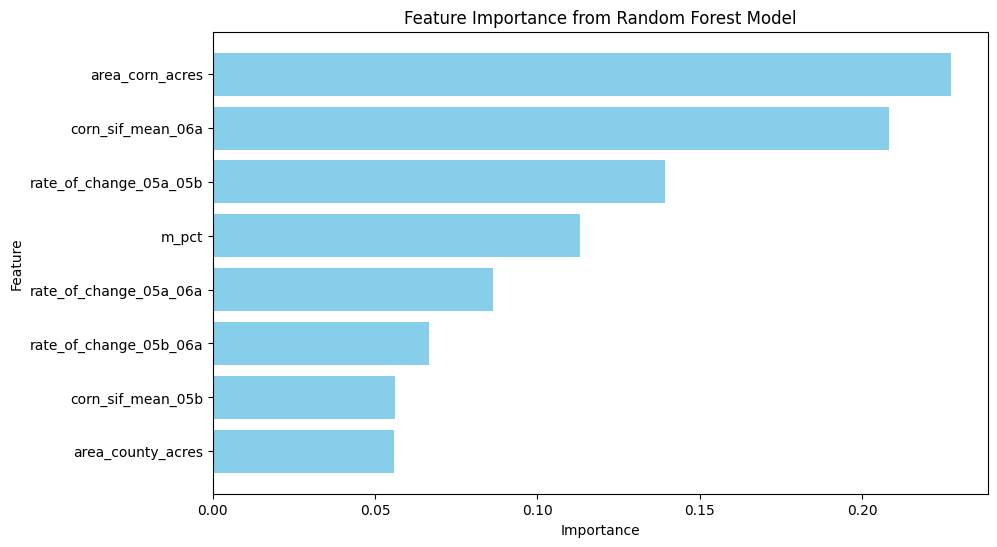

In [192]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Sort your data by year
df = df.sort_values(['year', 'GEOID']).reset_index(drop=True)

# Create rate of change features
df['rate_of_change_05a_05b'] = (df['corn_sif_mean_05b'] - df['corn_sif_mean_05a']) / df['corn_sif_mean_05a']
df['rate_of_change_05b_06a'] = (df['corn_sif_mean_06a'] - df['corn_sif_mean_05b']) / df['corn_sif_mean_05b']
# df['rate_of_change_06a_06b'] = (df['corn_sif_mean_06b'] - df['corn_sif_mean_06a']) / df['corn_sif_mean_06a']
df['rate_of_change_05a_06a'] = (df['corn_sif_mean_06a'] - df['corn_sif_mean_05a']) / df['corn_sif_mean_05a']

# Define predictive features and target
features = ['corn_sif_mean_05b','corn_sif_mean_05b', 'corn_sif_mean_06a','rate_of_change_05a_05b',
            'rate_of_change_05b_06a', 'rate_of_change_05a_06a',
            'area_corn_acres', 'area_county_acres','m_pct']
target = 'bushels_per_acre_actual'

# List unique years in ascending order
all_years = sorted(df['year'].unique())

model1 = []

# Walk-forward loop, year-by-year
for test_year in all_years[1:]:
    # Training and testing data
    train_data = df[df['year'] < test_year]
    test_data = df[df['year'] == test_year]
    
    if train_data.empty or test_data.empty:
        continue

    # Define X and y
    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    y_test = test_data[target]

    # Fit the Random Forest model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = rf.predict(X_test)

    # Store actual vs. predicted results along with GEOID
    for actual, predicted, geoid in zip(y_test, y_pred, test_data['GEOID']):
        model1.append({
            'year': test_year,
            'geoid': geoid,
            'actual': actual,
            'predicted': predicted
        })

# Convert to DataFrame
# Convert to DataFrame
model1_avg = pd.DataFrame(model1)
print(model1_avg)
# Average results by year
model1_avg = model1_avg.groupby('year').agg({
    'actual': 'mean',
    'predicted': 'mean',
}).reset_index()

model1_avg.rename(columns={'predicted': 'model1_pred'}, inplace=True)

# # Create a DataFrame with total area_corn_acres summed across all years
# total_area_corn_acres_by_year = df.groupby('year')['area_corn_acres'].mean().reset_index()

# # Add 'area_corn_acres' from the test_year to 'bushels_average' and calculate new columns
# model1_avg = model1_avg.merge(
#     total_area_corn_acres_by_year, 
#     on='year', 
#     how='left'
# )

# model1_avg['actual_bushels'] = model1_avg['actual'] / model1_avg['area_corn_acres']
# model1_avg['predicted_bushels'] = model1_avg['predicted'] / model1_avg['area_corn_acres']

# print(model1_avg.head())

print(model1_avg)

# Feature importance
rf.fit(df[features], df[target])
feature_importances = pd.DataFrame({'Feature': features, 'Importance': rf.feature_importances_}).sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importances)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest Model')
plt.gca().invert_yaxis()
plt.show()


   year        actual     predicted  area_corn_acres  actual_bushels  \
0  2016  2.768810e+07  2.573499e+07    136485.955280      202.864099   
1  2019  2.489039e+07  2.680088e+07    135042.093591      184.315824   
2  2020  2.316069e+07  2.662030e+07    137490.301153      168.453299   

   model2_predicted_bushels  
0                188.554158  
1                198.463192  
2                193.615864  
   year        actual     predicted  area_corn_acres  actual_bushels  \
0  2016  2.768810e+07  2.573499e+07    136485.955280      202.864099   
1  2019  2.489039e+07  2.680088e+07    135042.093591      184.315824   
2  2020  2.316069e+07  2.662030e+07    137490.301153      168.453299   

   model2_predicted_bushels  
0                188.554158  
1                198.463192  
2                193.615864  
Feature Importances:
                  Feature  Importance
6         area_corn_acres    0.895415
2       corn_sif_mean_06a    0.035955
8                   m_pct    0.015304
3  rate_o

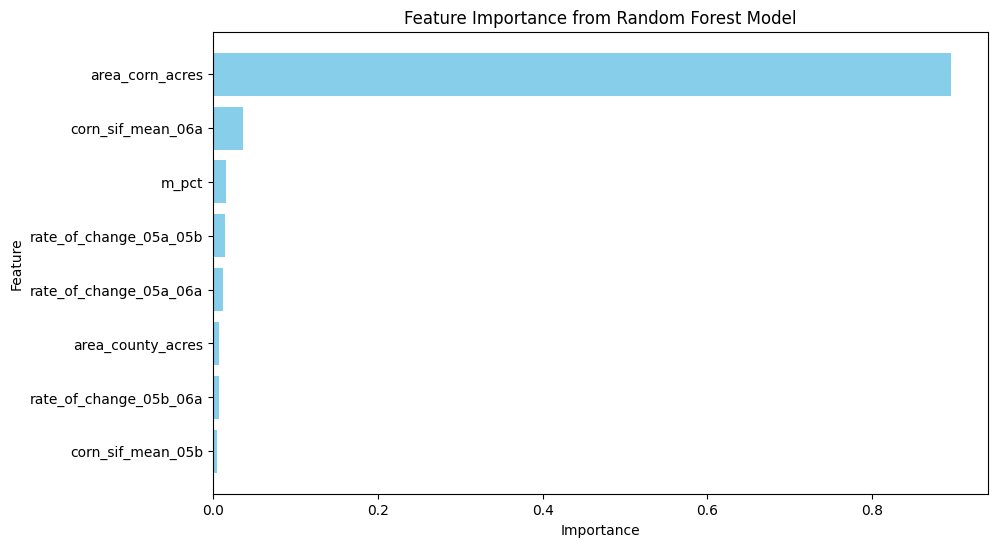

In [193]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Sort your data by year
df = df.sort_values(['year', 'GEOID']).reset_index(drop=True)

# Create rate of change features
df['rate_of_change_05a_05b'] = (df['corn_sif_mean_05b'] - df['corn_sif_mean_05a']) / df['corn_sif_mean_05a']
df['rate_of_change_05b_06a'] = (df['corn_sif_mean_06a'] - df['corn_sif_mean_05b']) / df['corn_sif_mean_05b']
# df['rate_of_change_06a_06b'] = (df['corn_sif_mean_06b'] - df['corn_sif_mean_06a']) / df['corn_sif_mean_06a']
df['rate_of_change_05a_06a'] = (df['corn_sif_mean_06a'] - df['corn_sif_mean_05a']) / df['corn_sif_mean_05a']

# Define predictive features and target
features = ['corn_sif_mean_05b','corn_sif_mean_05b', 'corn_sif_mean_06a','rate_of_change_05a_05b',
            'rate_of_change_05b_06a', 'rate_of_change_05a_06a',
            'area_corn_acres', 'area_county_acres','m_pct']
target = 'bushels_sum_actual'

# List unique years in ascending order
# all_years = sorted(df['year'].unique())

# Prepare data structure to save actual vs. predicted results
actual_vs_predicted = []

# Walk-forward loop, year-by-year
for test_year in all_years[1:]:
    # Training and testing data
    train_data = df[df['year'] < test_year]
    test_data = df[df['year'] == test_year]
    
    if train_data.empty or test_data.empty:
        continue

    # Define X and y
    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    y_test = test_data[target]

    # Fit the Random Forest model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = rf.predict(X_test)

    # Store actual vs. predicted results
    for actual, predicted in zip(y_test, y_pred):
        actual_vs_predicted.append({
            'year': test_year,
            'actual': actual,
            'predicted': predicted
        })

# Convert to DataFrame
actual_vs_predicted_df = pd.DataFrame(actual_vs_predicted)

# Average results by year
bushels_average = actual_vs_predicted_df.groupby('year').agg({
    'actual': 'mean',
    'predicted': 'mean',
}).reset_index()


# Create a DataFrame with total area_corn_acres summed across all years
total_area_corn_acres_by_year = df.groupby('year')['area_corn_acres'].mean().reset_index()

# Add 'area_corn_acres' from the test_year to 'bushels_average' and calculate new columns
bushels_average = bushels_average.merge(
    total_area_corn_acres_by_year, 
    on='year', 
    how='left'
)

bushels_average['actual_bushels'] = bushels_average['actual'] / bushels_average['area_corn_acres']
bushels_average['model2_predicted_bushels'] = bushels_average['predicted'] / bushels_average['area_corn_acres']

print(bushels_average.head())

print(bushels_average)

# Feature importance
rf.fit(df[features], df[target])
feature_importances = pd.DataFrame({'Feature': features, 'Importance': rf.feature_importances_}).sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importances)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest Model')
plt.gca().invert_yaxis()
plt.show()


In [194]:
print(prediction_table)


   year  Predicted Yield (baseline)  Actual Yield (USDA)  USDA June Actual
0  2015                      169.84                168.4             166.8
1  2016                      172.16                174.6             168.0
2  2017                      174.49                176.6             170.7
3  2018                      176.82                176.4             174.0
4  2019                      179.14                167.5             176.0
5  2020                      181.47                172.0             178.5
